# Classification Audio - TP

Explorons la classification de sons en utilisant les coefficients cepstraux à l'échelle de Mel (MFCC) comme critère principal.

Nous allons:
1. Charger des fichiers audio
2. Extraire les MFCC
3. Calculer les moyennes des MFCC pour avoir un critère instantané
4. Entraîner un classificateur simple
5. Évaluer les performances

## 1. Installation et importation des bibliothèques nécessaires

In [11]:
# Installation des bibliothèques (à exécuter si nécessaire)
# !pip install librosa numpy matplotlib scikit-learn pandas tensorflow

In [12]:
# Importation des bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from IPython.display import Audio

# Pour être sûr que les graphiques s'affichent dans le notebook
%matplotlib inline

## 2. Chargement des données

Notre ensemble de données audio a la structure suivante:
```
data/
├── [fichiers .wav]
├── train/
│   ├── cat/
│   │   └── [fichiers .wav]
│   └── dogs/
│       └── [fichiers .wav]
└── test/
    ├── cats/
        └── [fichiers .wav]
    └── dogs/
        └── [fichiers .wav]
```

Nous allons charger les données d'entraînement et de test séparément, en utilisant la structure existante.

In [13]:
# Définir le chemin du dossier principal contenant les données
data_folder = 'data'  # Changez ceci selon votre structure de dossier

# Fonction pour extraire les MFCC moyens d'un fichier audio
def extract_mfcc_mean(file_path, n_mfcc=13):
    try:
        # Chargement du fichier audio
        y, sr = librosa.load(file_path, sr=None)
        
        # Extraction des MFCC
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        
        # Calcul de la moyenne pour chaque coefficient MFCC
        mfcc_mean = np.mean(mfccs, axis=1)
        
        return mfcc_mean
    except Exception as e:
        print(f"Erreur lors du traitement de {file_path}: {e}")
        return None

# Fonction pour charger les données d'un dossier et extraire les caractéristiques
def load_data_from_folder(folder_path, class_label=None):
    features = []
    labels = []
    
    # Si aucune classe n'est fournie, utiliser les noms des sous-dossiers comme classes
    if class_label is None:
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            
            if os.path.isdir(item_path):
                print(f"Traitement du dossier: {item}")
                item_features, item_labels = load_data_from_folder(item_path, item)
                features.extend(item_features)
                labels.extend(item_labels)
            elif item.endswith('.wav'):
                mfcc_mean = extract_mfcc_mean(item_path)
                if mfcc_mean is not None:
                    features.append(mfcc_mean)
                    # Utiliser le nom du dossier parent comme étiquette
                    labels.append(os.path.basename(folder_path))
    else:
        # Si une classe est fournie, traiter tous les fichiers du dossier avec cette classe
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)
            
            if item.endswith('.wav'):
                mfcc_mean = extract_mfcc_mean(item_path)
                if mfcc_mean is not None:
                    features.append(mfcc_mean)
                    labels.append(class_label)
    
    return features, labels

# Chargement des données d'entraînement
print("Chargement des données d'entraînement...")
train_folder = os.path.join(data_folder, 'train')
train_features, train_labels = load_data_from_folder(train_folder)

# Conversion en arrays numpy
X_train = np.array(train_features)
y_train = np.array(train_labels)

print(f"Nombre d'échantillons d'entraînement: {len(X_train)}")
print(f"Classes d'entraînement: {np.unique(y_train)}")

# Chargement des données de test
print("\nChargement des données de test...")
test_folder = os.path.join(data_folder, 'test')
test_features, test_labels = load_data_from_folder(test_folder)

# Conversion en arrays numpy
X_test = np.array(test_features)
y_test = np.array(test_labels)

print(f"Nombre d'échantillons de test: {len(X_test)}")
print(f"Classes de test: {np.unique(y_test)}")


Chargement des données d'entraînement...
Traitement du dossier: cats
Traitement du dossier: dogs
Nombre d'échantillons d'entraînement: 210
Classes d'entraînement: ['cats' 'dogs']

Chargement des données de test...
Traitement du dossier: cats
Traitement du dossier: dogs
Nombre d'échantillons de test: 67
Classes de test: ['cats' 'dogs']


## 3. Exploration des données

Visualisons les MFCC moyens pour quelques exemples de chaque classe.

In [14]:
# Création d'un DataFrame pour les données d'entraînement
df_train = pd.DataFrame(X_train)
df_train['classe'] = y_train

# Affichage des premières lignes
print("Aperçu des données d'entraînement:")
df_train.head()

Aperçu des données d'entraînement:


,0,1,2,3,4,5,6,7,8,9,10,11,12,classe
0,-280.531189,102.627457,-1.959248,23.931303,0.135133,3.842995,-5.380228,2.154289,-2.085963,2.617188,-1.659218,-2.106714,-6.985489,cats
1,-252.982513,-27.048912,-50.957966,1.482292,-10.462673,-6.344731,-12.192235,16.146687,2.947798,0.514347,-0.572208,-3.147739,-10.980074,cats
2,-162.667328,60.527145,-18.757477,23.866247,-11.752433,20.026281,-5.787396,0.485016,-9.911298,11.273782,5.935657,28.916605,-6.389854,cats
3,-236.200745,63.843697,-33.040451,-12.063961,-19.351400,-5.738749,-21.550455,-4.539681,-8.254208,-10.276299,-12.665183,-6.291096,-12.090069,cats
4,-248.669922,75.222198,-33.077869,-14.091416,-19.237738,-5.105680,-21.466278,-5.813075,-7.323204,-8.552026,-12.850485,-9.417410,-12.328292,cats


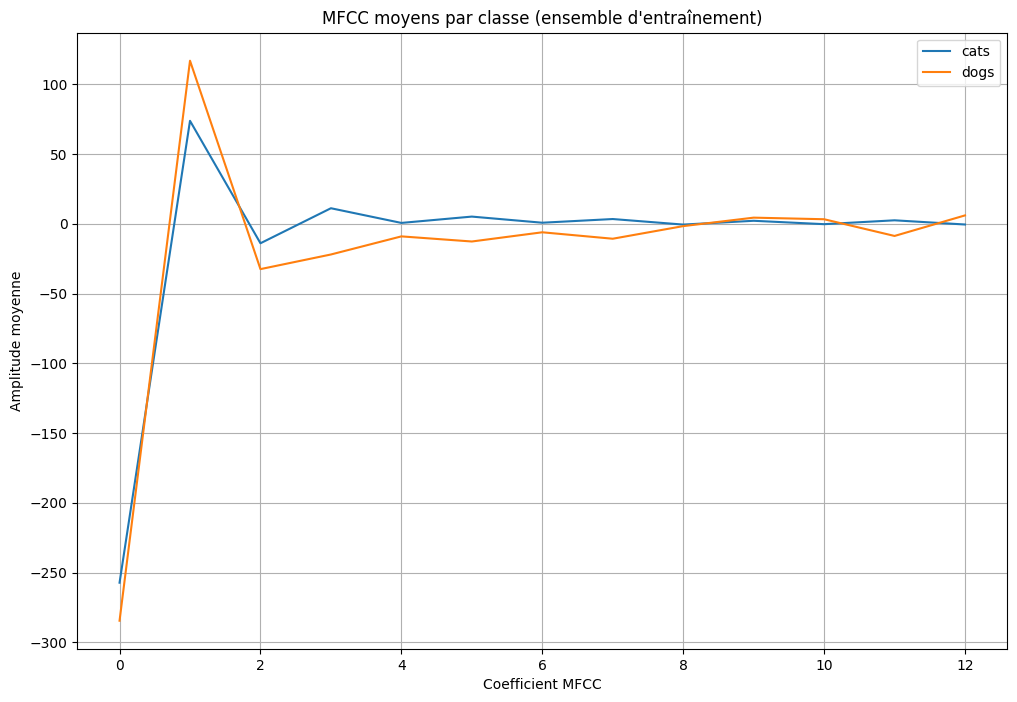

In [15]:
# Visualisation des MFCC moyens par classe pour les données d'entraînement
plt.figure(figsize=(12, 8))

for classe in np.unique(y_train):
    # Sélection des données pour cette classe
    classe_data = X_train[y_train == classe]
    
    # Calcul de la moyenne des MFCC pour cette classe
    mean_mfcc = np.mean(classe_data, axis=0)
    
    # Tracé
    plt.plot(mean_mfcc, label=classe)

plt.title('MFCC moyens par classe (ensemble d\'entraînement)')
plt.xlabel('Coefficient MFCC')
plt.ylabel('Amplitude moyenne')
plt.legend()
plt.grid(True)
plt.show()

## 4. Préparation des données pour la classification

In [16]:
# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Taille de l'ensemble d'entraînement: {X_train.shape}")
print(f"Taille de l'ensemble de test: {X_test.shape}")

Taille de l'ensemble d'entraînement: (210, 13)
Taille de l'ensemble de test: (67, 13)


## 5. Entraînement du modèle

Nous utiliserons un SVM (Support Vector Machine) simple pour la classification.

In [17]:
# Création et entraînement du modèle
model = SVC(kernel='rbf', C=10, gamma='scale', probability=True)
model.fit(X_train_scaled, y_train)

# Prédictions sur l'ensemble d'entraînement
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Précision sur l'ensemble d'entraînement: {train_accuracy:.4f}")

Précision sur l'ensemble d'entraînement: 0.9905


## 6. Évaluation du modèle

Précision sur l'ensemble de test: 0.8358

Rapport de classification:
              precision    recall  f1-score   support

        cats       0.85      0.87      0.86        39
        dogs       0.81      0.79      0.80        28

    accuracy                           0.84        67
   macro avg       0.83      0.83      0.83        67
weighted avg       0.84      0.84      0.84        67



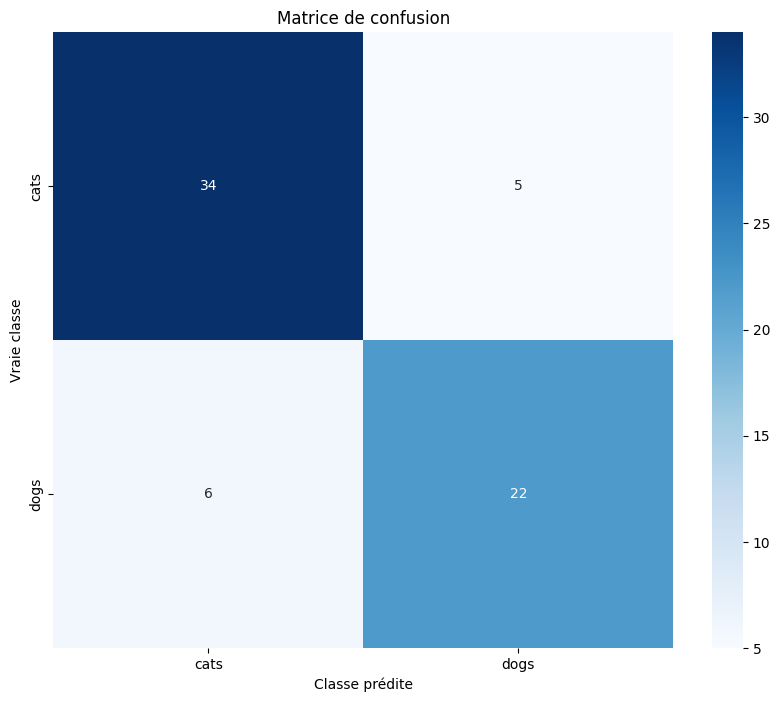

In [18]:
# Prédictions sur l'ensemble de test
y_test_pred = model.predict(X_test_scaled)

# Calcul de la précision
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Précision sur l'ensemble de test: {test_accuracy:.4f}")

# Rapport de classification détaillé
print("\nRapport de classification:")
print(classification_report(y_test, y_test_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Matrice de confusion')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.show()

## 7. Test avec un nouvel échantillon audio

In [19]:
# Fonction pour prédire la classe d'un fichier audio
def predict_audio_class(file_path, model, scaler):
    # Extraction des MFCC moyens
    mfcc_mean = extract_mfcc_mean(file_path)
    
    if mfcc_mean is not None:
        # Préparation des données
        mfcc_mean = mfcc_mean.reshape(1, -1)
        mfcc_mean_scaled = scaler.transform(mfcc_mean)
        
        # Prédiction
        prediction = model.predict(mfcc_mean_scaled)[0]
        probabilities = model.predict_proba(mfcc_mean_scaled)[0]
        
        # Recherche de l'indice de la classe prédite
        pred_index = np.where(model.classes_ == prediction)[0][0]
        
        return prediction, probabilities[pred_index]
    else:
        return None, None


test_file = 'data/test/cats/cat_59.wav'
print(f"Test avec le fichier: {test_file}")

# Écoute du fichier audio
y_test_audio, sr_test_audio = librosa.load(test_file, sr=None)
display(Audio(y_test_audio, rate=sr_test_audio))

# Prédiction
predicted_class, confidence = predict_audio_class(test_file, model, scaler)

if predicted_class is not None:
    print(f"Classe prédite: {predicted_class}")
    print(f"Confiance: {confidence:.4f}")

Test avec le fichier: data/test/cats/cat_59.wav


Classe prédite: cats
Confiance: 0.8610


## 8. Exploration des autres descripteurs audio

Dans ce TP, nous avons utilisé uniquement les MFCC comme critère pour la classification. Voici comment on pourrait explorer d'autres descripteurs mentionnés :

In [20]:
# Fonction pour extraire plusieurs descripteurs audio
def extract_audio_features(file_path):
    try:
        # Chargement du fichier audio
        y, sr = librosa.load(file_path, sr=None)
        
        # MFCC (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfcc_mean = np.mean(mfccs, axis=1)
        
        # RMS (Root Mean Square)
        rms = librosa.feature.rms(y=y)[0]
        rms_mean = np.mean(rms)
        
        # ZCR (Zero Crossing Rate)
        zcr = librosa.feature.zero_crossing_rate(y=y)[0]
        zcr_mean = np.mean(zcr)
        
        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
        spectral_centroid_mean = np.mean(spectral_centroid)
        
        # Spectral Bandwidth
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)[0]
        spectral_bandwidth_mean = np.mean(spectral_bandwidth)
        
        # Spectral Rolloff
        spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)[0]
        spectral_rolloff_mean = np.mean(spectral_rolloff)
        
        # Rassemblement des caractéristiques
        features = {
            'mfcc_mean': mfcc_mean,
            'rms_mean': rms_mean,
            'zcr_mean': zcr_mean,
            'spectral_centroid_mean': spectral_centroid_mean,
            'spectral_bandwidth_mean': spectral_bandwidth_mean,
            'spectral_rolloff_mean': spectral_rolloff_mean
        }
        
        return features
    except Exception as e:
        print(f"Erreur lors du traitement de {file_path}: {e}")
        return None

## 9. Conclusion

Dans ce TP, nous avons:
1. Chargé des données audio à partir d'une structure de dossiers spécifique
2. Extrait les MFCC de fichiers audio
3. Calculé les moyennes des MFCC pour avoir un critère instantané
4. Entraîné un modèle SVM pour la classification
5. Évalué les performances du modèle

Pour améliorer ce système, on peut :
- Utiliser plus de descripteurs audio
- Essayer différents algorithmes de classification
- Appliquer des techniques de sélection de caractéristiques
- Utiliser des réseaux de neurones pour le traitement de séquences temporelles